In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.append('../../../../../do-mpc/')
import do_mpc
import pandas as pd
import scipy.io as sio
import pathlib
import pandas as pd

In [2]:
mpl.rcParams.update({
    'lines.linewidth':2,
    'font.size': 16,
    'figure.figsize': (9, 6),
    'axes.grid': False,
    'lines.markersize': 10,
    'text.usetex': True,
    'axes.unicode_minus': False,
    'ps.fonttype': 42,
    'pdf.fonttype': 42
})

In [3]:
%matplotlib notebook

In [12]:
plan_name = 'kite_validation_01'
model_name = 'S01_NN_M01'
load_name = f'./{plan_name}/{plan_name}.pkl'

plan = do_mpc.tools.load_pickle(load_name)
    
dh_bll = do_mpc.sampling.DataHandler(plan)
dh_bll.set_param(data_dir = f'./{plan_name}/{model_name}/with_bll_cons/')

dh_std = do_mpc.sampling.DataHandler(plan)
dh_std.set_param(data_dir = f'./{plan_name}/{model_name}/wo_bll_cons/')

dh_ref = do_mpc.sampling.DataHandler(plan)
dh_ref.set_param(data_dir = f'./{plan_name}/Reference/')

In [17]:
for dh in [dh_bll, dh_std, dh_ref]:
    dh.set_post_processing('T_F', lambda data: data[0]['_aux', 'T_F'])
    dh.set_post_processing('height', lambda data: data[0]['_aux', 'height_kite'])
    dh.set_post_processing('traj_len', lambda data: data[0]['_x'].shape[0])
    dh.set_post_processing('T_f_tot', lambda data: np.sum(data[0]['_aux', 'T_F']))
    dh.set_post_processing('states', lambda data: data[0]['_x'])
    if dh in [dh_bll, dh_std]:
        dh.set_post_processing('bll_trust', lambda data: data[1]['_aux','bll_trust'])
    
    dh.set_post_processing('mpc_sol_time', lambda data: data[1]['t_wall_total'])
    
    
    
df_std = pd.DataFrame(dh_std[:])
df_bll = pd.DataFrame(dh_bll[:])
df_ref = pd.DataFrame(dh_ref[:])

# Plots and performance indicators for inspection

<IPython.core.display.Javascript object>


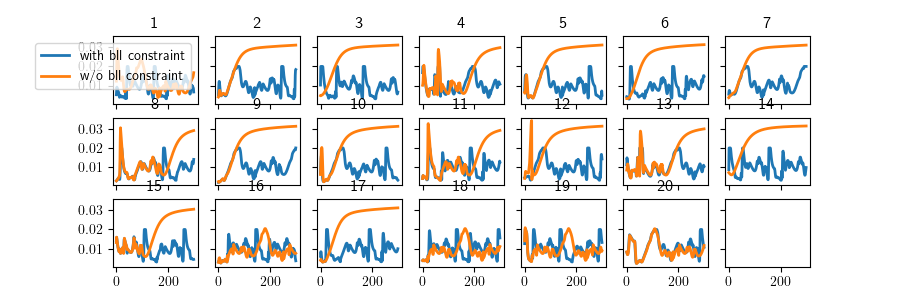

In [14]:
n_res = min(len(df_std),20)

n_row = int(np.ceil(np.sqrt(n_res)))
n_row = 3
n_col = int(np.ceil(n_res/n_row))

fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(9,3))

for dh in [dh_bll, dh_std]:
    for i in range(n_res):
        ax[i//n_col, np.mod(i,n_col)].plot(dh[i][0]['bll_trust'])
        ax[i//n_col, np.mod(i,n_col)].set_title(i+1)


ax[0,0].set_prop_cycle(None)
ax[0,0].plot([],[],label='with bll constraint')
ax[0,0].plot([],[],label='w/o bll constraint')
ax[0,0].legend()

<IPython.core.display.Javascript object>


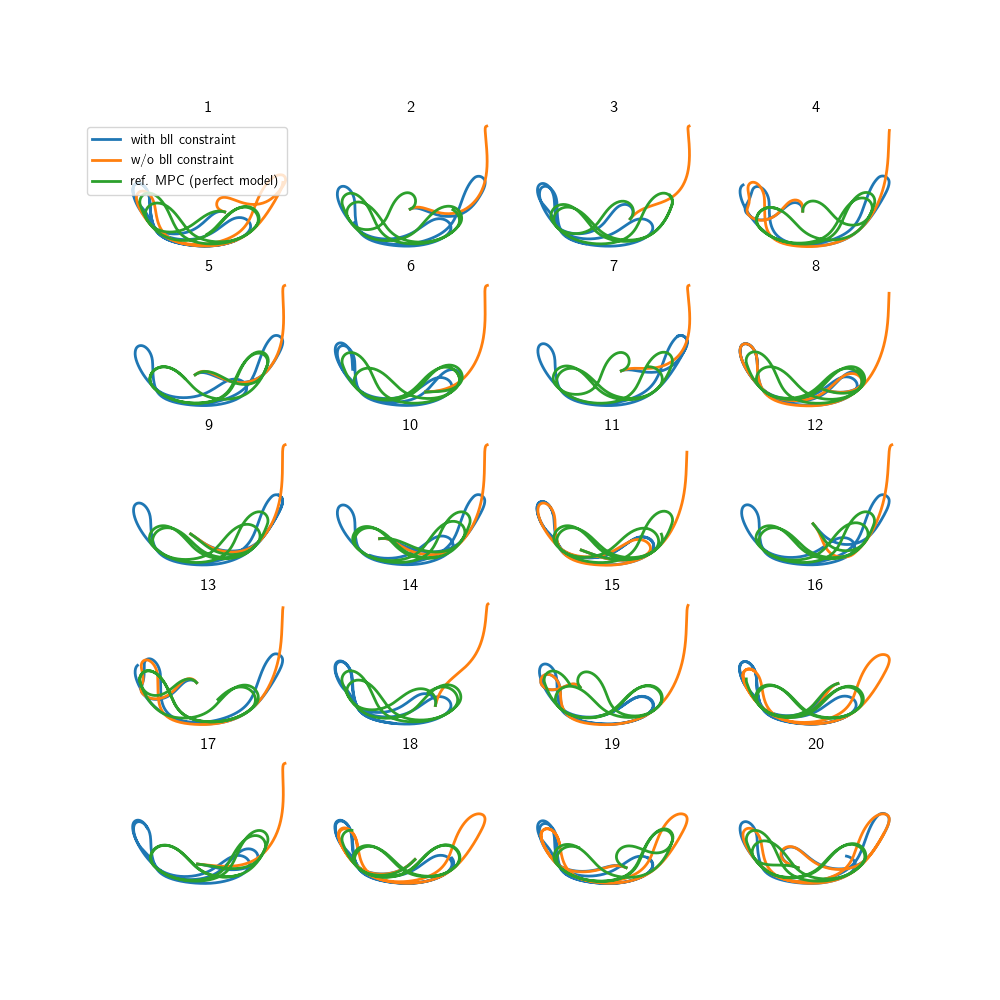

In [20]:
n_res = min(len(df_bll),20)

n_row = int(np.ceil(np.sqrt(n_res)))
n_col = int(np.ceil(n_res/n_row))


fig, ax = plt.subplots(n_row, n_col, sharex=True, sharey=True, figsize=(10,10))

for dh in [dh_bll, dh_std, dh_ref]:
    for i in range(n_res):
        ax[i//n_col, np.mod(i,n_col)].plot(dh[i][0]['states'][:,1],dh[i][0]['states'][:,0])
        ax[i//n_col, np.mod(i,n_col)].axis('off')
        ax[i//n_col, np.mod(i,n_col)].set_title(i+1)


ax[0,0].set_prop_cycle(None)
ax[0,0].plot([],[],label='with bll constraint')
ax[0,0].plot([],[],label='w/o bll constraint')
ax[0,0].plot([],[],label='ref. MPC (perfect model)')
ax[0,0].legend()
    
#fig.tight_layout(pad=0)



In [18]:
T_f_tot_std = df_std['T_f_tot']
T_f_tot_bll = df_bll['T_f_tot']
T_f_tot_ref = df_ref['T_f_tot']

<IPython.core.display.Javascript object>


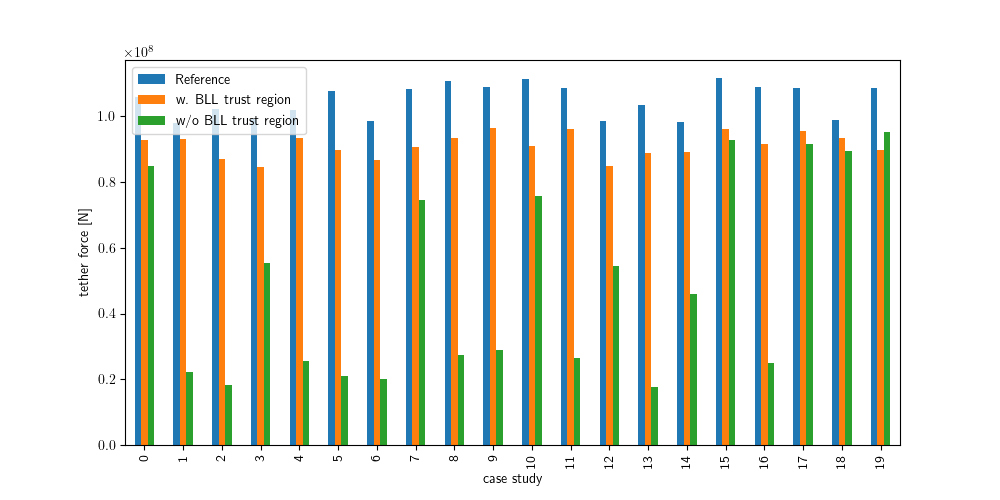

<AxesSubplot:xlabel='case study', ylabel='tether force [N]'>

In [34]:
df_tether_force = pd.DataFrame({'Reference':T_f_tot_ref, 
                                'w. BLL trust region': T_f_tot_bll, 
                                'w/o BLL trust region': T_f_tot_std})

fig,ax = plt.subplots(figsize=(10,5))
df_tether_force.plot.bar(ax=ax, xlabel='case study', ylabel='tether force [N]')

In [27]:
dTf_bll_vs_ref = np.mean(100*(T_f_tot_bll-T_f_tot_ref)/T_f_tot_ref)
dTf_std_vs_ref = np.mean(100*(T_f_tot_std-T_f_tot_ref)/T_f_tot_ref)

print(f'Reduced total tether force BLL-MPC vs. reference: {dTf_bll_vs_ref:.1f}%')
print(f'Reduced total tether force BLL-MPC vs. reference: {dTf_std_vs_ref:.1f}%')

Reduced total tether force BLL-MPC vs. reference: -12.9%
Reduced total tether force BLL-MPC vs. reference: -52.9%


In [55]:
mean_sol_time_bll = np.mean(np.concatenate([(dh_i['mpc_sol_time']) for dh_i in dh_bll[:]]))
mean_sol_time_std = np.mean(np.concatenate([(dh_i['mpc_sol_time']) for dh_i in dh_std[:]]))

std_sol_time_bll = np.std(np.concatenate([(dh_i['mpc_sol_time']) for dh_i in dh_bll[:]]))
std_sol_time_std = np.std(np.concatenate([(dh_i['mpc_sol_time']) for dh_i in dh_std[:]]))

print(f'Median computation time for bll. NN: {1000*mean_sol_time_bll:.0f}+-{1000*std_sol_time_bll:.0f} ms')
print(f'Median computation time for reg. NN: {1000*mean_sol_time_std:.0f}+-{1000*std_sol_time_std:.0f} ms')

Median computation time for bll. NN: 575+-461 ms
Median computation time for reg. NN: 250+-333 ms


## Plots for publication

<IPython.core.display.Javascript object>


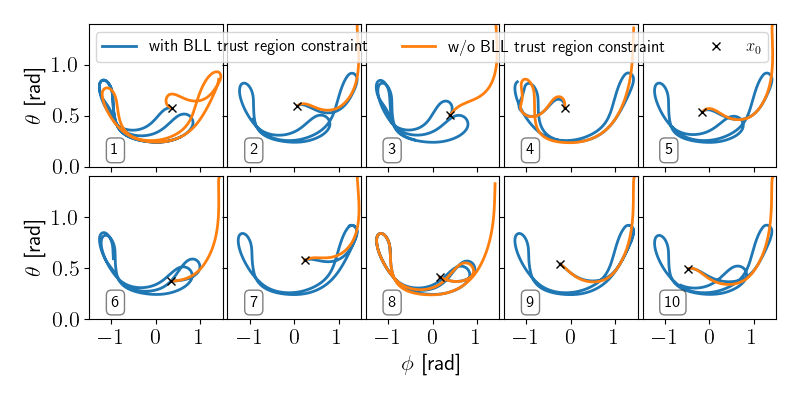

In [40]:
n_eval = 6

cases = list(range(10))
n_res = 10

assert len(cases)==n_res

n_row = 2
n_col = 5


fig, ax = plt.subplots(n_row,n_col,sharex=True,sharey=True, figsize=(8,4))


box_props = dict(boxstyle='round', edgecolor='black', facecolor='white', alpha=0.5)


for i in range(n_res):
    ax[i//n_col, np.mod(i,n_col)].text(-1,0.12,i+1, bbox=box_props, fontsize=12)
    ax[i//n_col, np.mod(i,n_col)].plot(dh_bll[i][0]['states'][:,1],dh_bll[i][0]['states'][:,0],
                                       label='with BLL trust region constraint')
    ax[i//n_col, np.mod(i,n_col)].plot(dh_std[i][0]['states'][:,1],dh_std[i][0]['states'][:,0],
                                      label='w/o BLL trust region constraint')
    ax[i//n_col, np.mod(i,n_col)].plot(dh_bll[i][0]['states'][0,1],dh_bll[i][0]['states'][0,0], 'x', color='k',
                                       label='$x_0$', markersize=6)
    

ax[0,0].set_ylabel(r'$\theta$ [rad]') 
ax[1,0].set_ylabel(r'$\theta$ [rad]')
ax[1,n_col//2].set_xlabel(r'$\phi$ [rad]')

fig.tight_layout(h_pad=0, w_pad=0)
ax[0,4].legend(ncol=3,loc=1, fontsize=12)

ax[0,0].set_xlim(-1.5,1.5)
ax[0,0].set_ylim(0,1.4)

fig.savefig('Kite_NN_MPC_w_wo_BLL_cons.pdf',format='pdf', pad_inches=0)